### Import modules + Check GPU

In [91]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from skimage import io
from tqdm import tqdm
import scipy.ndimage
from torch.utils.tensorboard import SummaryWriter

# for SSIM
import math

# for beta selection
import random

In [2]:
print("GPU available: {}".format(torch.cuda.is_available()))
print("Device: {}".format(torch.cuda.get_device_name(0)))

GPU available: True
Device: Tesla K80


### Data Generation

In [3]:
def isotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None):

    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.] * img.ndim)

    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]

    
    time = 0
    
    results_pixels = []
    results_dIdt = []
    results_time = []
    
    results_pixels.append(out.astype(img.dtype))
    results_time.append(time)
    #results_dIdt.append(np.zeros_like(out))

    for iter in tqdm(range(niter)):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            diff_local = np.diff(out, axis=i)
            deltas[i][tuple(slicer)] = diff_local

        matrices = [delta for delta, spacing in zip(deltas, voxelspacing)]

        # second derivative
        for i in range(out.ndim):
            slicer = [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)

        
        dIdt = np.sum(matrices, axis=0)
        #print(dIdt)
        
        # update the image
        out += gamma * (dIdt)
        time += gamma
        
        results_dIdt.append(dIdt.astype(img.dtype))
        if iter < niter - 1:
            results_pixels.append(out.astype(img.dtype))
            results_time.append(time)

    return results_pixels, results_dIdt, results_time

def get_mgrid(sidelen=256, dim=2):
    
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    
    return mgrid

class ImageFitting(Dataset):
    
    def __init__(self, img_path, niter):
        
        self.transform = Compose([
            Resize(256),
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
        ])
        self.coords = get_mgrid()
        
        print("-----Generating Data-----")
        self.base_img = io.imread(img_path)
        self.imgs_pixels, self.imgs_dIdt, self.imgs_time = isotropic_diffusion(self.base_img, niter=niter, kappa=50, gamma=1/(niter+1))

        print("-----Finished-----")
        
        self.len = len(self.imgs_pixels)
        
    def __len__(self):
        
        return self.len
    
    def __getitem__(self, idx):

        image = self.imgs_pixels[idx]
        image = self.transform(Image.fromarray(image))
        
        pixels = image.permute(1, 2, 0).view(-1, 1)
        step_val = torch.full((self.coords.size(0),1), self.imgs_time[idx])

        model_input = torch.cat((self.coords, step_val), 1)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(image.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(image.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        laplace = scipy.ndimage.laplace(image.numpy()).squeeze(0)[..., None]
        laplace = torch.from_numpy(laplace).view(-1, 1)
        
        dIdt = torch.from_numpy(self.imgs_dIdt[idx])
        dIdt = dIdt.permute(0,1).view(-1)
        
        return model_input, {'pixels':pixels, 'grads':grads, 'laplace':laplace, 'dIdt':dIdt}

### Loss Calculation

In [4]:
def computeJacobianFull(x, outputs, create_graph):
    
    dy_dx = torch.autograd.grad(outputs=outputs, inputs=x, grad_outputs=torch.ones_like(outputs),
            retain_graph=True, create_graph=create_graph, allow_unused=True)[0]
    
    dy_dx = dy_dx.view(outputs.size(0), outputs.size(1), dy_dx.size(2))
    
    return dy_dx

def computeLaplaceFull(x, jacobian, create_graph):
    
    div = 0
    for j in range(jacobian.size(-1)):

        dy_dx2 = torch.autograd.grad(outputs=jacobian[:, :, j], inputs=x, grad_outputs=torch.ones_like(jacobian[:, :, j]),
            retain_graph=True, create_graph=create_graph)[0][..., j:j+1]

        div += dy_dx2

    return div

def calcLoss(coords, model_output, gt):
    
    pixel_loss = ((model_output - gt['pixels'])**2).mean()
    
    gradients = computeJacobianFull(coords, model_output, create_graph=True)
    grad_loss = ((gradients[:,:,:-1] - gt['grads']).pow(2).sum(-1)).mean()
    
    laplacian = computeLaplaceFull(coords, gradients[:,:,:-1], create_graph=False)
    laplacian_loss = ((laplacian - gt['laplace'])**2).mean()
    
    dIdt_loss = ((gradients[:,:,-1] - gt['dIdt'])**2).mean()
    
    return pixel_loss, grad_loss, laplacian_loss, dIdt_loss


### SSIM (Structural Similarity Index Measure)
original SSIM paper: https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf \
code source: https://github.com/pranjaldatta/SSIM-PyTorch \
explanation: https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e

In [161]:
# helper function for SSIM
def gaussian(window_size=16, sigma=1.5):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

# helper function for SSIM
def create_window(window_size=16, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

# mean SSIM with SSIM applied locally over moving windows
# output = 1: the same image, output = 0 (or -1): very different
def mean_ssim(img1, img2, val_range, window_size=16, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((1, 0))).unsqueeze(0).float().div(255.0)

In [167]:
def calcSSIM(model_output, gt):
    print("model_output: ")
    print(type(model_output))
    print(np.shape(model_output))
    
    print("gt['pixels']: ")
    print(type(gt['pixels']))
    print(np.shape(gt['pixels']))
    return
    
    pixel_loss = ((model_output - gt['pixels'])**2).mean()
    
    #gradients = computeJacobianFull(coords, model_output, create_graph=True)
    grad_loss = ((gradients[:,:,:-1] - gt['grads']).pow(2).sum(-1)).mean()
    
    #laplacian = computeLaplaceFull(coords, gradients[:,:,:-1], create_graph=False)
    laplacian_loss = ((laplacian - gt['laplace'])**2).mean()
    
    dIdt_loss = ((gradients[:,:,-1] - gt['dIdt'])**2).mean()
    
    return pixel_loss, grad_loss, laplacian_loss, dIdt_loss

In [86]:
# ### Example Usage ###

# img_path_temp = 'original/cameraman.png'
# img1 = io.imread(img_path_temp)
# img2 = io.imread(img_path_temp)

# # Check SSIM score of True image vs False Image
# _img1 = tensorify(img1)
# _img2 = tensorify(img2)
# true_vs_false = mean_ssim(_img1, _img2, val_range=255)
# print("True vs False Image SSIM Score:", true_vs_false)

True vs False Image SSIM Score: tensor(1.)


### SIREN Network Architecture

In [5]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

### ELU Network Architecture

In [6]:
class ELULayer(nn.Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            nn.init.xavier_uniform_(self.linear.weight)
        
    def forward(self, input):
        return F.elu(self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.linear(input)
        return F.elu(intermediate), intermediate
    
    
class Base(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(ELULayer(in_features, hidden_features))

        for i in range(hidden_layers):
            self.net.append(ELULayer(hidden_features, hidden_features))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                nn.init.xavier_uniform_(final_linear.weight)
                
            self.net.append(final_linear)
        else:
            self.net.append(ELULayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

### Train Network

In [163]:
def train(net, writer, img_path, niter, total_epochs=50, lr=[1e-4], beta_0=1, beta_1=1, beta_2=1, beta_3=1, 
          cyclic=False, decay_exp=False, decay_multi=False):
    
    """Args:
        net: Network to Train
        writer: SummaryWriter for logging
        img_path: path to default state image
        niter: number of steps to apply diffusion (0 means only 1 image)
        total_epochs: number of epochs to train
        beta_0: constant for loss on pixel value
        beta_1: constant for loss on gradients
        beta_2: constant for loss on laplacian
        beta_3: constant for loss on pixel time derivative
        cyclic: CyclicLearning rate (allows better learning)"""
    
    
    image = ImageFitting(img_path=img_path, niter=niter)
    dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

    net.cuda()

    epochs_til_summary = 5 #UPDATE ACCORDINGLY
    steps_til_summary = 1 #UPDATE ACCORDINGLY

    optim = torch.optim.Adam(lr=lr[0], params=net.parameters())
    
    if decay_multi:
        m = np.floor(total_epochs/4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[m*1,m*2,m*3], gamma=0.1)
    
    if decay_exp:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
    
    if cyclic:
        scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=lr[1], max_lr=lr[0], step_size_up=250, cycle_momentum=False)
    
    print("-----Begin Training-----")
    for epoch in range(1, total_epochs + 1):
        
        epoch_loss = 0.0
        epoch_pixel_loss = 0.0
        epoch_grad_loss = 0.0
        epoch_laplacian_loss = 0.0
        epoch_dIdt_loss = 0.0

        for step, batch in tqdm(enumerate(dataloader)):

            model_input = batch[0].cuda()
            gt = {key: value.cuda() for key, value in batch[1].items()}

            model_output, coords = net(model_input)   
            
            pixel_loss, grad_loss, laplacian_loss, dIdt_loss = calcLoss(coords, model_output, gt)
            calcSSIM(model_output, gt)
            return
            #pixel_ssim, grad_ssim, laplacian_ssim, dIdt_ssim = calcSSIM(model_output, gt)
            
            loss = beta_0 * pixel_loss + beta_1 * grad_loss + beta_2 * laplacian_loss + beta_3 * dIdt_loss
            
            epoch_loss += model_output.shape[0] * loss.item()
            epoch_pixel_loss += model_output.shape[0] * pixel_loss.item()
            epoch_grad_loss += model_output.shape[0] * grad_loss.item()
            epoch_laplacian_loss += model_output.shape[0] * laplacian_loss.item()
            epoch_dIdt_loss += model_output.shape[0] * dIdt_loss.item()

            if not epoch % epochs_til_summary and step % steps_til_summary == steps_til_summary - 1:

                pixel_output = model_output[0].view(1, -1, 256, 256)
                pixel_gt = gt['pixels'][0].view(1, -1, 256, 256)
                img_grid_pixel = torchvision.utils.make_grid(torch.cat((pixel_gt, pixel_output), 0), 2)
                img_grid_pixel = img_grid_pixel * 0.5 + 0.5
                writer.add_image('pixels', img_grid_pixel, epoch * len(dataloader) + step + 1)
                
                
                img_grad = computeJacobianFull(coords, model_output, create_graph=True)
                grad_output = img_grad[0,:,:-1].norm(dim=-1).view(1, -1, 256, 256)
                grad_gt = gt['grads'][0].norm(dim=-1).view(1, -1, 256, 256)
                img_grid_grad = torchvision.utils.make_grid(torch.cat((grad_gt, grad_output), 0), 2)
                writer.add_image('grads', img_grid_grad, epoch * len(dataloader) + step + 1)
                
                
                img_laplacian = computeLaplaceFull(coords, img_grad, create_graph=False)
                laplacian_output = img_laplacian[0].view(1, -1, 256, 256)
                laplacian_gt = gt['laplace'][0].view(1, -1, 256, 256)
                img_grid_laplacian = torchvision.utils.make_grid(torch.cat((laplacian_gt, laplacian_output), 0), 2)
                writer.add_image('laplacians', img_grid_laplacian, epoch * len(dataloader) + step + 1)
                
                dIdt_output = img_grad[0,:,-1].view(1, -1, 256, 256)
                dIdt_gt = gt['dIdt'][0].view(1, -1, 256, 256)
                img_grid_dIdt = torchvision.utils.make_grid(torch.cat((dIdt_gt, dIdt_output), 0), 2)
                writer.add_image('dIdt', img_grid_dIdt, epoch * len(dataloader) + step + 1)

                fig, axes = plt.subplots(2,4, figsize=(18,6))
                axes[0,0].imshow(gt['pixels'][0].cpu().view(256,256).detach().numpy())
                axes[0,1].imshow(gt['grads'][0].norm(dim=-1).cpu().view(256,256).detach().numpy())
                axes[0,2].imshow(gt['laplace'][0].cpu().view(256,256).detach().numpy())
                axes[0,3].imshow(gt['dIdt'][0].cpu().view(256,256).detach().numpy())
                axes[1,0].imshow(model_output[0].cpu().view(256,256).detach().numpy())
                axes[1,1].imshow(img_grad[0][:,:-1].norm(dim=-1).cpu().view(256,256).detach().numpy())
                axes[1,2].imshow(img_laplacian[0].cpu().view(256,256).detach().numpy())
                axes[1,3].imshow(img_grad[0][:,-1].cpu().view(256,256).detach().numpy())
                plt.show()

            optim.zero_grad()
            loss.backward()
            optim.step()

            if cyclic or decay_exp or decay_multi:
                scheduler.step()
        
        # logging epoch loss
        writer.add_scalar('epoch_loss/total', epoch_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/pixel', epoch_pixel_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/grad', epoch_grad_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/laplacian', epoch_laplacian_loss/len(image), epoch)
        writer.add_scalar('epoch_loss/dIdt', epoch_dIdt_loss/len(image), epoch)
        print("epoch %d, Epoch loss: total %0.6f, pixel %0.6f, grad %0.6f, laplacian %0.6f, dIdt %0.6f" % (epoch, epoch_loss/len(image), epoch_pixel_loss/len(image), epoch_grad_loss/len(image), epoch_laplacian_loss/len(image), epoch_dIdt_loss/len(image)))
    
    writer.add_graph(net, model_input)
    print("-----Finished-----")
                

### Baselines

#### SIREN Baselines

In [168]:
# SIREN, learn only with the observed pixel values
writer = SummaryWriter('runs/siren/cameraman_experiment_pixels')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=10, total_epochs=10, beta_0=1, beta_1=0, beta_2=0, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 10/10 [00:00<00:00, 1720.81it/s]


-----Finished-----
-----Begin Training-----


0it [00:00, ?it/s]

model_output: 
<class 'torch.Tensor'>
torch.Size([1, 65536, 1])
gt['pixels']: 
<class 'torch.Tensor'>
torch.Size([1, 65536, 1])


-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 1038.71it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.12it/s]


epoch 1, Epoch loss: total 14.665578, pixel 0.327748, grad 14.665578, laplacian 38.155090, dIdt 25862.378906


1it [00:01,  1.18s/it]


epoch 2, Epoch loss: total 13.695274, pixel 0.284576, grad 13.695274, laplacian 273.408783, dIdt 25857.921875


1it [00:01,  1.18s/it]


epoch 3, Epoch loss: total 13.277464, pixel 0.273272, grad 13.277464, laplacian 475.693970, dIdt 25859.410156


1it [00:01,  1.19s/it]


epoch 4, Epoch loss: total 12.942521, pixel 0.246908, grad 12.942521, laplacian 1208.247559, dIdt 25860.056641


0it [00:00, ?it/s]

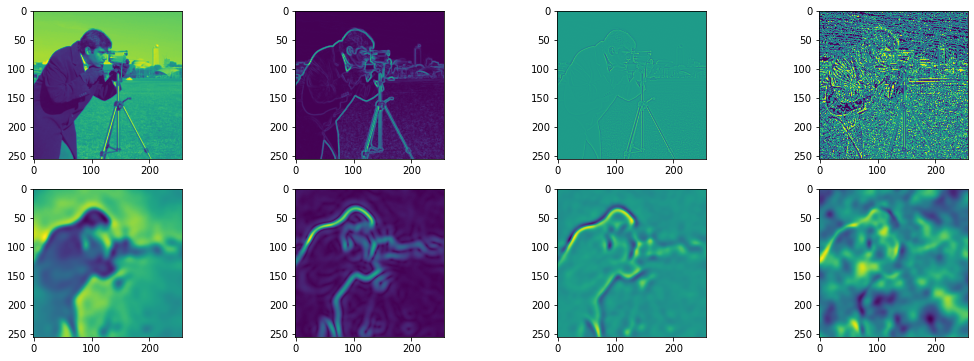

1it [00:03,  3.42s/it]


epoch 5, Epoch loss: total 12.655024, pixel 0.236781, grad 12.655024, laplacian 1793.954834, dIdt 25860.976562


1it [00:01,  1.17s/it]


epoch 6, Epoch loss: total 12.205709, pixel 0.238653, grad 12.205709, laplacian 2236.034180, dIdt 25860.929688


1it [00:01,  1.18s/it]


epoch 7, Epoch loss: total 12.187681, pixel 0.229454, grad 12.187681, laplacian 4246.456055, dIdt 25857.939453


1it [00:01,  1.19s/it]


epoch 8, Epoch loss: total 12.146305, pixel 0.224576, grad 12.146305, laplacian 5759.656738, dIdt 25858.066406


1it [00:01,  1.19s/it]


epoch 9, Epoch loss: total 11.353464, pixel 0.224715, grad 11.353464, laplacian 5448.061035, dIdt 25858.621094


0it [00:00, ?it/s]

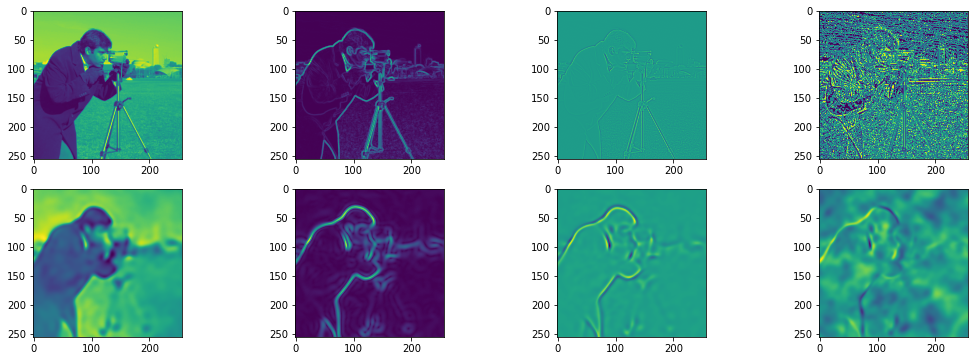

1it [00:03,  3.53s/it]


epoch 10, Epoch loss: total 11.371170, pixel 0.223471, grad 11.371170, laplacian 6837.753418, dIdt 25859.507812
-----Finished-----


In [9]:
# SIREN, learn only with the observed jacobians (first derivative in space)
writer = SummaryWriter('runs/siren/cameraman_experiment_grads')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=1, beta_2=0, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 957.82it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.11it/s]


epoch 1, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.17s/it]


epoch 2, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.16s/it]


epoch 3, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.16s/it]


epoch 4, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


0it [00:00, ?it/s]

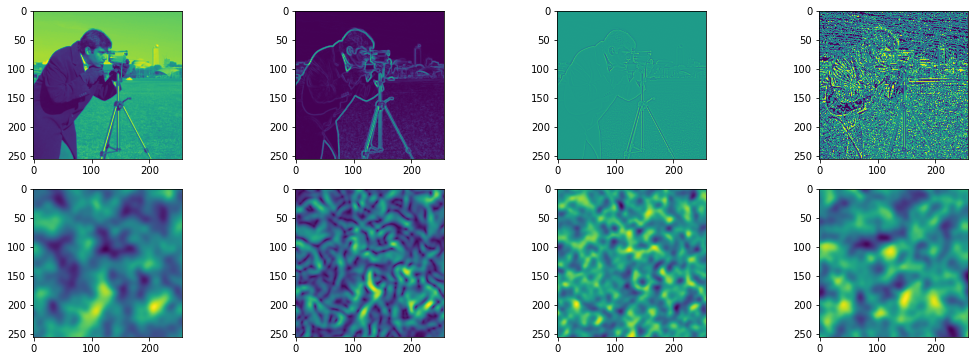

1it [00:03,  3.38s/it]


epoch 5, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.14s/it]


epoch 6, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.17s/it]


epoch 7, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.16s/it]


epoch 8, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


1it [00:01,  1.16s/it]


epoch 9, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672


0it [00:00, ?it/s]

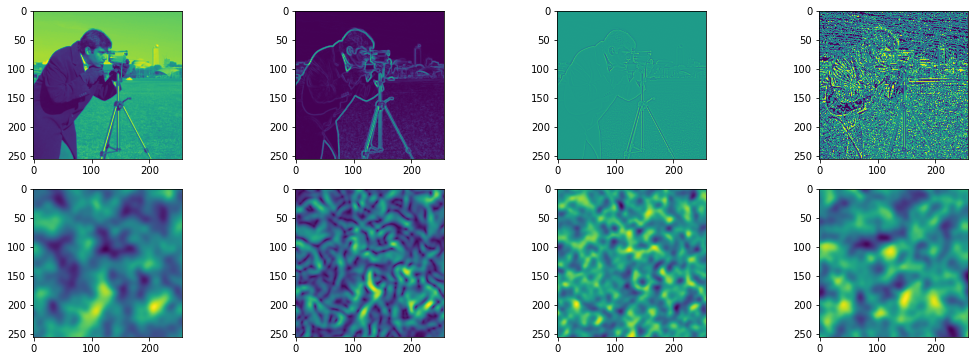

1it [00:03,  3.41s/it]


epoch 10, Epoch loss: total 37.902321, pixel 0.327401, grad 14.584696, laplacian 37.902321, dIdt 25872.263672
-----Finished-----


In [10]:
# SIREN, learns only with the observed laplacians (2nd derivative in space)
writer = SummaryWriter('runs/siren/cameraman_experiment_laplace')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=1, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 674.76it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.11it/s]


epoch 1, Epoch loss: total 25869.148438, pixel 0.324637, grad 14.638735, laplacian 37.753830, dIdt 25869.148438


1it [00:01,  1.19s/it]


epoch 2, Epoch loss: total 25515.236328, pixel 0.321269, grad 14.657439, laplacian 60.573441, dIdt 25515.236328


1it [00:01,  1.20s/it]


epoch 3, Epoch loss: total 25009.939453, pixel 0.317338, grad 14.901340, laplacian 152.241562, dIdt 25009.939453


1it [00:01,  1.18s/it]


epoch 4, Epoch loss: total 24176.330078, pixel 0.315786, grad 15.515373, laplacian 371.071503, dIdt 24176.330078


0it [00:00, ?it/s]

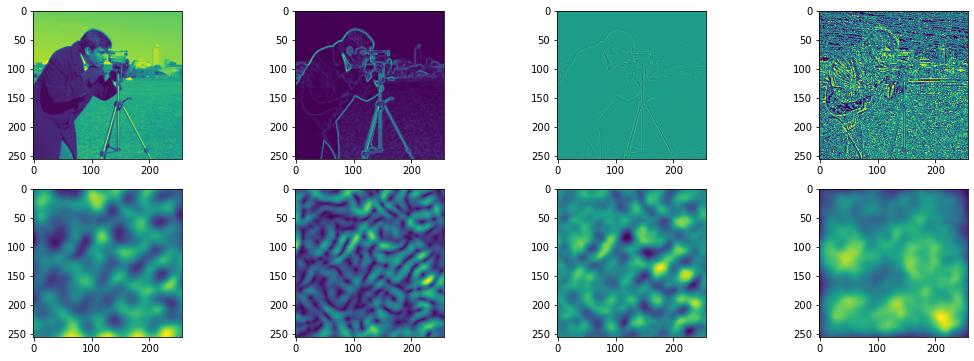

1it [00:03,  3.64s/it]


epoch 5, Epoch loss: total 22787.496094, pixel 0.323785, grad 16.802643, laplacian 847.616699, dIdt 22787.496094


1it [00:01,  1.18s/it]


epoch 6, Epoch loss: total 20674.171875, pixel 0.344054, grad 19.112171, laplacian 1748.714233, dIdt 20674.171875


1it [00:01,  1.20s/it]


epoch 7, Epoch loss: total 18489.515625, pixel 0.397319, grad 21.413509, laplacian 2832.222168, dIdt 18489.515625


1it [00:01,  1.20s/it]


epoch 8, Epoch loss: total 24238.234375, pixel 0.877809, grad 18.338146, laplacian 1600.651123, dIdt 24238.234375


1it [00:01,  1.19s/it]


epoch 9, Epoch loss: total 16585.261719, pixel 0.686595, grad 28.356289, laplacian 4553.241211, dIdt 16585.261719


0it [00:00, ?it/s]

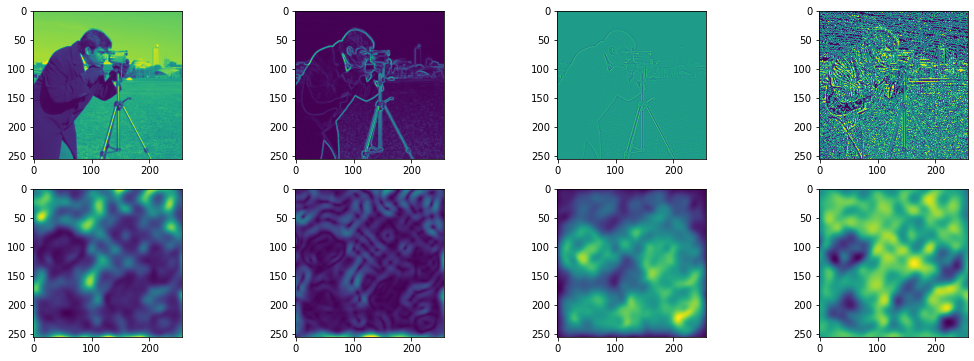

1it [00:03,  3.51s/it]


epoch 10, Epoch loss: total 21551.609375, pixel 1.134464, grad 19.194271, laplacian 2083.239502, dIdt 21551.609375
-----Finished-----


In [11]:
# SIREN, learn only with the observed derivative in time (3rd derivative)
writer = SummaryWriter('runs/siren/cameraman_experiment_dIdt')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=0, beta_3=1)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 963.99it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.11it/s]


epoch 1, Epoch loss: total 26.398621, pixel 0.331532, grad 14.729111, laplacian 45.935570, dIdt 25873.859375


1it [00:01,  1.19s/it]


epoch 2, Epoch loss: total 26.398096, pixel 0.331423, grad 14.728326, laplacian 45.921032, dIdt 25873.466797


1it [00:01,  1.18s/it]


epoch 3, Epoch loss: total 26.395481, pixel 0.330874, grad 14.724413, laplacian 45.850117, dIdt 25871.511719


1it [00:01,  1.19s/it]


epoch 4, Epoch loss: total 26.390789, pixel 0.329890, grad 14.717424, laplacian 45.730934, dIdt 25867.992188


0it [00:00, ?it/s]

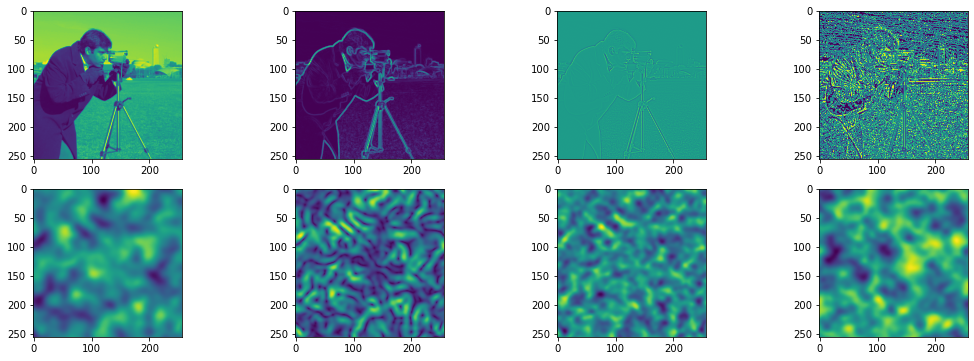

1it [00:03,  3.43s/it]


epoch 5, Epoch loss: total 26.384041, pixel 0.328475, grad 14.707456, laplacian 45.578186, dIdt 25862.912109


1it [00:01,  1.17s/it]


epoch 6, Epoch loss: total 26.375273, pixel 0.326638, grad 14.694646, laplacian 45.413712, dIdt 25856.273438


1it [00:01,  1.18s/it]


epoch 7, Epoch loss: total 26.364521, pixel 0.324386, grad 14.679172, laplacian 45.266151, dIdt 25848.074219


1it [00:01,  1.19s/it]


epoch 8, Epoch loss: total 26.351831, pixel 0.321731, grad 14.661243, laplacian 45.170910, dIdt 25838.316406


1it [00:01,  1.18s/it]


epoch 9, Epoch loss: total 26.337255, pixel 0.318682, grad 14.641105, laplacian 45.169910, dIdt 25826.990234


0it [00:00, ?it/s]

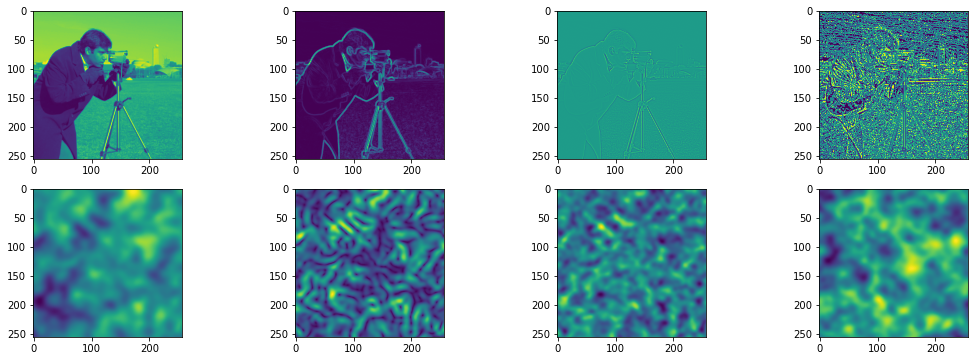

1it [00:03,  3.61s/it]


epoch 10, Epoch loss: total 26.320835, pixel 0.315247, grad 14.619023, laplacian 45.311226, dIdt 25814.085938
-----Finished-----


In [12]:
# SIREN, learn with all data, equally weighted
writer = SummaryWriter('runs/siren/cameraman_experiment_all')

img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_siren, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=1, beta_2=1, beta_3=1, cyclic=True)

writer.close()

#### Elu Baselines

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 901.42it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.19it/s]


epoch 1, Epoch loss: total 0.445817, pixel 0.445817, grad 14.592905, laplacian 0.062803, dIdt 25868.828125


1it [00:01,  1.13s/it]


epoch 2, Epoch loss: total 0.534592, pixel 0.534592, grad 14.589285, laplacian 0.062672, dIdt 25873.365234


1it [00:01,  1.13s/it]


epoch 3, Epoch loss: total 0.396364, pixel 0.396364, grad 14.578516, laplacian 0.062624, dIdt 25873.335938


1it [00:01,  1.15s/it]


epoch 4, Epoch loss: total 0.310762, pixel 0.310762, grad 14.571904, laplacian 0.062685, dIdt 25872.546875


0it [00:00, ?it/s]

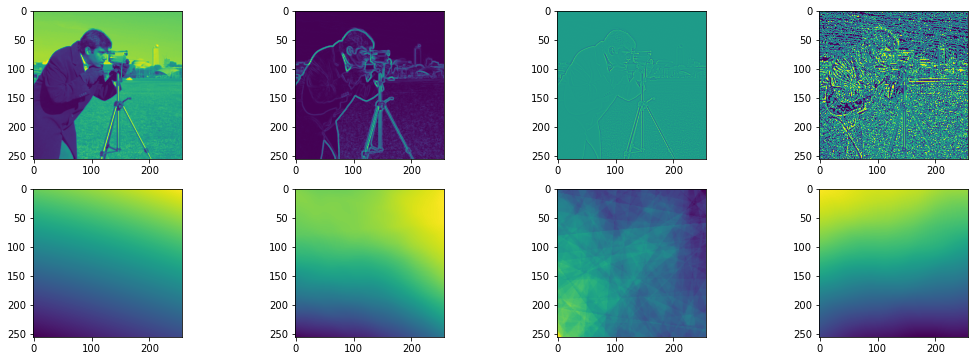

1it [00:03,  3.20s/it]


epoch 5, Epoch loss: total 0.364946, pixel 0.364946, grad 14.569904, laplacian 0.062839, dIdt 25872.304688


1it [00:01,  1.14s/it]


epoch 6, Epoch loss: total 0.354859, pixel 0.354859, grad 14.573349, laplacian 0.062884, dIdt 25873.105469


1it [00:01,  1.15s/it]


epoch 7, Epoch loss: total 0.283472, pixel 0.283472, grad 14.581443, laplacian 0.062830, dIdt 25874.623047


1it [00:01,  1.14s/it]


epoch 8, Epoch loss: total 0.252723, pixel 0.252723, grad 14.593721, laplacian 0.062770, dIdt 25876.398438


1it [00:01,  1.14s/it]


epoch 9, Epoch loss: total 0.276071, pixel 0.276071, grad 14.610170, laplacian 0.062768, dIdt 25877.929688


0it [00:00, ?it/s]

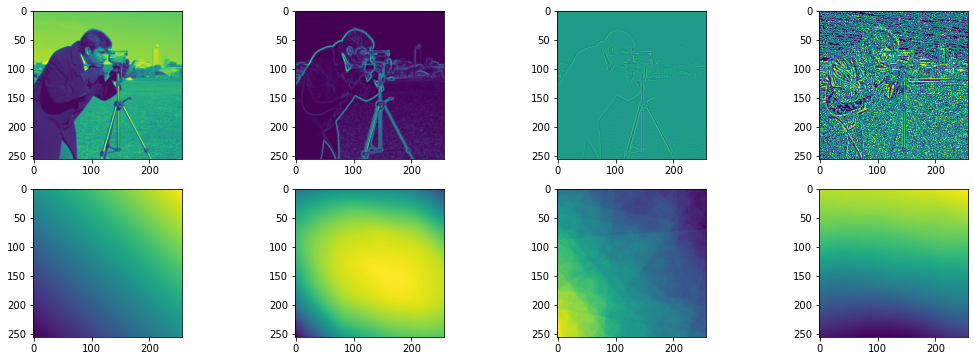

1it [00:03,  3.29s/it]


epoch 10, Epoch loss: total 0.283644, pixel 0.283644, grad 14.630144, laplacian 0.062811, dIdt 25878.849609
-----Finished-----


In [13]:
# Base, learn only with the observed pixel values
writer = SummaryWriter('runs/base/cameraman_experiment_pixels')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=0, beta_2=0, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 703.62it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.16it/s]


epoch 1, Epoch loss: total 14.574642, pixel 0.362422, grad 14.574642, laplacian 0.062623, dIdt 25841.974609


1it [00:01,  1.16s/it]


epoch 2, Epoch loss: total 14.571012, pixel 0.361162, grad 14.571012, laplacian 0.062690, dIdt 25845.580078


1it [00:01,  1.15s/it]


epoch 3, Epoch loss: total 14.571445, pixel 0.420224, grad 14.571445, laplacian 0.062897, dIdt 25846.269531


1it [00:01,  1.15s/it]


epoch 4, Epoch loss: total 14.565933, pixel 0.486393, grad 14.565933, laplacian 0.063151, dIdt 25845.681641


0it [00:00, ?it/s]

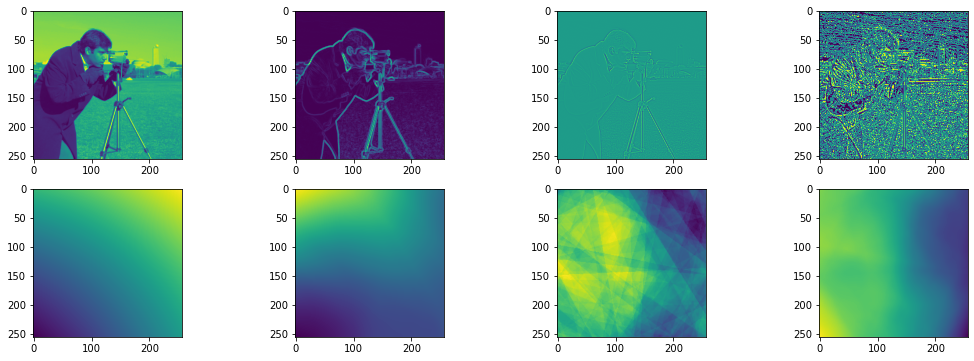

1it [00:03,  3.40s/it]


epoch 5, Epoch loss: total 14.564613, pixel 0.557296, grad 14.564613, laplacian 0.063468, dIdt 25844.917969


1it [00:01,  1.14s/it]


epoch 6, Epoch loss: total 14.566112, pixel 0.634589, grad 14.566112, laplacian 0.063906, dIdt 25844.644531


1it [00:01,  1.15s/it]


epoch 7, Epoch loss: total 14.565180, pixel 0.716376, grad 14.565180, laplacian 0.064463, dIdt 25845.082031


1it [00:01,  1.15s/it]


epoch 8, Epoch loss: total 14.562488, pixel 0.803871, grad 14.562488, laplacian 0.065115, dIdt 25846.009766


1it [00:01,  1.15s/it]


epoch 9, Epoch loss: total 14.560987, pixel 0.897390, grad 14.560987, laplacian 0.065851, dIdt 25847.097656


0it [00:00, ?it/s]

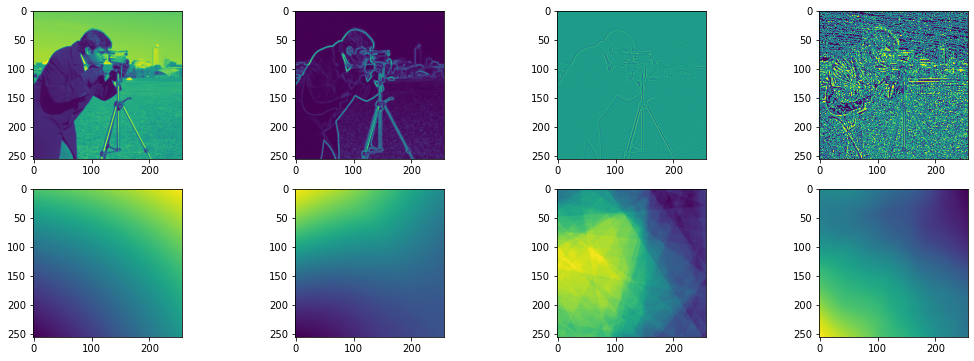

1it [00:03,  3.28s/it]


epoch 10, Epoch loss: total 14.561251, pixel 0.996522, grad 14.561251, laplacian 0.066692, dIdt 25848.062500
-----Finished-----


In [14]:
# Base, learn only with the observed jacobians (first derivative in space)
writer = SummaryWriter('runs/base/cameraman_experiment_grads')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=1, beta_2=0, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 1032.06it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.17it/s]


epoch 1, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.13s/it]


epoch 2, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.11s/it]


epoch 3, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.13s/it]


epoch 4, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


0it [00:00, ?it/s]

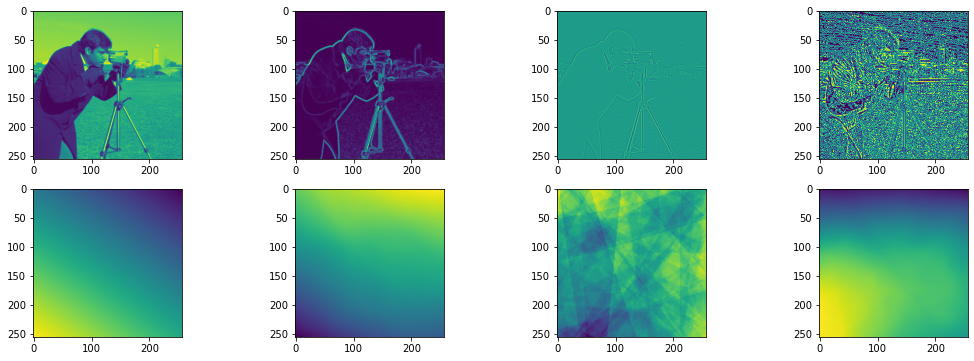

1it [00:03,  3.25s/it]


epoch 5, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.12s/it]


epoch 6, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.12s/it]


epoch 7, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.12s/it]


epoch 8, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


1it [00:01,  1.12s/it]


epoch 9, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438


0it [00:00, ?it/s]

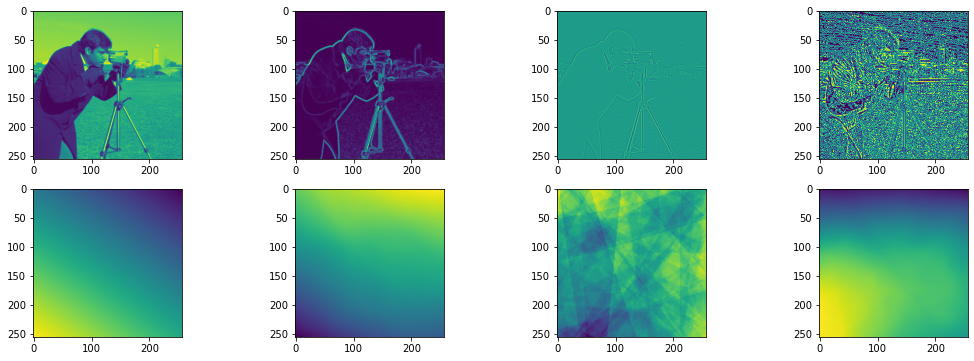

1it [00:03,  3.40s/it]


epoch 10, Epoch loss: total 0.062838, pixel 0.594254, grad 14.616716, laplacian 0.062838, dIdt 25865.773438
-----Finished-----


In [15]:
# Base, learn only with the observed laplacians (2nd derivative in space)
writer = SummaryWriter('runs/base/cameraman_experiment_laplace')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=1, beta_3=0)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 838.19it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.17it/s]


epoch 1, Epoch loss: total 25859.613281, pixel 0.317208, grad 14.578131, laplacian 0.062636, dIdt 25859.613281


1it [00:01,  1.14s/it]


epoch 2, Epoch loss: total 25827.576172, pixel 0.322313, grad 14.575609, laplacian 0.062641, dIdt 25827.576172


1it [00:01,  1.14s/it]


epoch 3, Epoch loss: total 25795.453125, pixel 0.328185, grad 14.573951, laplacian 0.062644, dIdt 25795.453125


1it [00:01,  1.14s/it]


epoch 4, Epoch loss: total 25762.789062, pixel 0.334719, grad 14.573141, laplacian 0.062653, dIdt 25762.789062


0it [00:00, ?it/s]

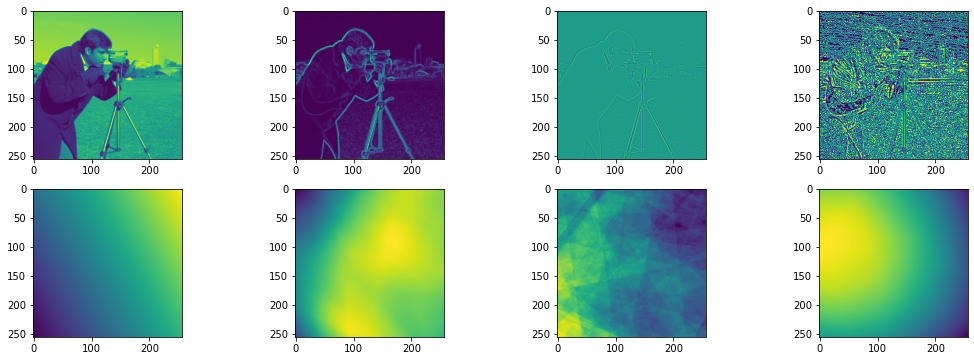

1it [00:03,  3.27s/it]


epoch 5, Epoch loss: total 25729.195312, pixel 0.341558, grad 14.573121, laplacian 0.062665, dIdt 25729.195312


1it [00:01,  1.13s/it]


epoch 6, Epoch loss: total 25694.326172, pixel 0.348225, grad 14.573897, laplacian 0.062674, dIdt 25694.326172


1it [00:01,  1.15s/it]


epoch 7, Epoch loss: total 25657.847656, pixel 0.354433, grad 14.575478, laplacian 0.062684, dIdt 25657.847656


1it [00:01,  1.15s/it]


epoch 8, Epoch loss: total 25619.460938, pixel 0.359890, grad 14.577831, laplacian 0.062693, dIdt 25619.460938


1it [00:01,  1.15s/it]


epoch 9, Epoch loss: total 25578.828125, pixel 0.363870, grad 14.581091, laplacian 0.062704, dIdt 25578.828125


0it [00:00, ?it/s]

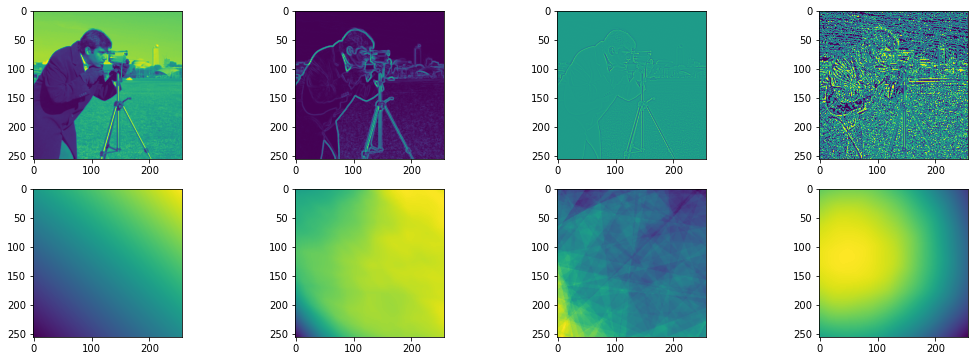

1it [00:03,  3.28s/it]


epoch 10, Epoch loss: total 25535.519531, pixel 0.366598, grad 14.585333, laplacian 0.062713, dIdt 25535.519531
-----Finished-----


In [16]:
# Base, learn only with the observed derivative in time (3rd derivative)
writer = SummaryWriter('runs/base/cameraman_experiment_dIdt')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=0, beta_1=0, beta_2=0, beta_3=1)

writer.close()

-----Generating Data-----


100%|██████████| 1/1 [00:00<00:00, 685.90it/s]


-----Finished-----
-----Begin Training-----


1it [00:00,  1.17it/s]


epoch 1, Epoch loss: total 25883.376953, pixel 0.471587, grad 14.585213, laplacian 0.062658, dIdt 25868.257812


1it [00:01,  1.15s/it]


epoch 2, Epoch loss: total 25852.386719, pixel 0.517091, grad 14.583698, laplacian 0.062675, dIdt 25837.222656


1it [00:01,  1.15s/it]


epoch 3, Epoch loss: total 25821.656250, pixel 0.570509, grad 14.582312, laplacian 0.062699, dIdt 25806.441406


1it [00:01,  1.15s/it]


epoch 4, Epoch loss: total 25790.902344, pixel 0.630361, grad 14.581118, laplacian 0.062725, dIdt 25775.628906


0it [00:00, ?it/s]

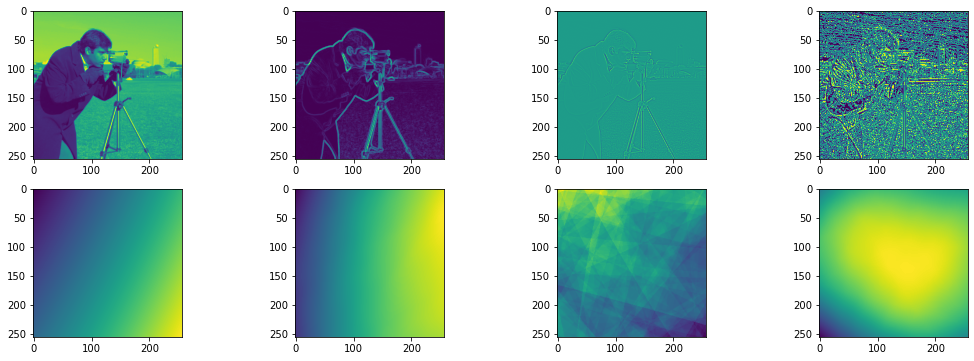

1it [00:03,  3.37s/it]


epoch 5, Epoch loss: total 25759.742188, pixel 0.696514, grad 14.580065, laplacian 0.062752, dIdt 25744.402344


1it [00:01,  1.15s/it]


epoch 6, Epoch loss: total 25727.953125, pixel 0.768672, grad 14.579128, laplacian 0.062785, dIdt 25712.542969


1it [00:01,  1.14s/it]


epoch 7, Epoch loss: total 25695.207031, pixel 0.843896, grad 14.578259, laplacian 0.062829, dIdt 25679.722656


1it [00:01,  1.15s/it]


epoch 8, Epoch loss: total 25661.236328, pixel 0.921016, grad 14.577373, laplacian 0.062883, dIdt 25645.675781


1it [00:01,  1.14s/it]


epoch 9, Epoch loss: total 25625.742188, pixel 0.998853, grad 14.576527, laplacian 0.062942, dIdt 25610.103516


0it [00:00, ?it/s]

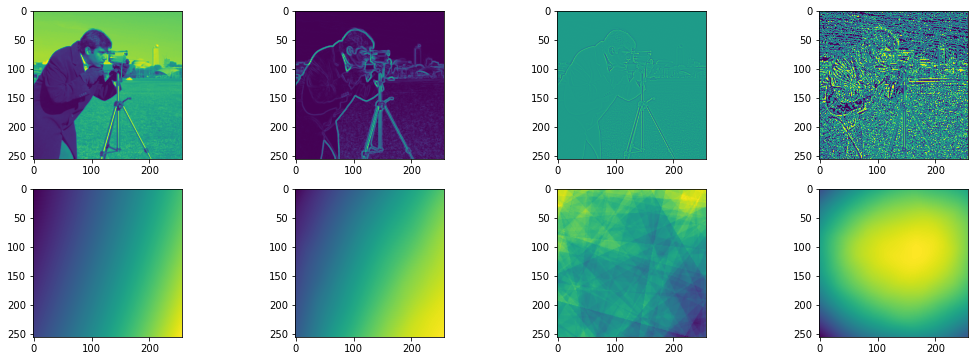

1it [00:03,  3.25s/it]


epoch 10, Epoch loss: total 25588.357422, pixel 1.078212, grad 14.575739, laplacian 0.063009, dIdt 25572.640625
-----Finished-----


In [17]:
# Base, learn with all data, equally weighted
writer = SummaryWriter('runs/base/cameraman_experiment_all')

img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)

train(img_base, writer, img_path='original/cameraman.png', niter=1, total_epochs=10, beta_0=1, beta_1=1, beta_2=1, beta_3=1)

writer.close()

### Experiments

#### Experiments Helper Functions

In [139]:
# @min_beta_sum: minimum sum of all four beta values
# @return: a list of 4 beta values, summing to at least min_beta_sum
def generate_random_beta_combos(min_beta_sum=0.3):
    possible_values = [1.0, 0.1, 0.01, 0.001, 0.0]
    betas = [0, 0, 0, 0]
    
    while np.sum(betas) <= min_beta_sum:
        betas = [random.choice(possible_values) for i in range(4)]
        
    return betas

# @betas: a list of beta values
# @return: a string with '_' between all beta values
def b_to_string(betas):
    return '_'.join(map(str, betas))

In [159]:
# runs one experiment with the elu activation function
def run_elu(model_path, betas, total_epochs, lr, cyclic=False, decay_exp=False, decay_multi=False):
    writer = SummaryWriter(model_path)
    
    img_base = Base(in_features=3, out_features=1, hidden_features=512, 
                    hidden_layers=3, outermost_linear=True)
    
    train(img_base, writer, img_path='original/cameraman.png', niter=10, 
          total_epochs=total_epochs, lr=lr,
          beta_0=betas[0], beta_1=betas[1], beta_2=betas[2], beta_3=betas[3], 
          cyclic=cyclic, decay_exp=decay_exp, decay_multi=decay_multi)
    
    writer.close()

In [160]:
# runs one experiment with the SIREN (periodic) activation function
def run_siren(model_path, betas, total_epochs, lr, cyclic=False, decay_exp=False, decay_multi=False):
    writer = SummaryWriter(model_path)
    
    img_siren = Siren(in_features=3, out_features=1, hidden_features=512, 
                      hidden_layers=3, outermost_linear=True)
    
    train(img_siren, writer, img_path='original/cameraman.png', niter=10, 
          total_epochs=total_epochs, lr=lr,
          beta_0=betas[0], beta_1=betas[1], beta_2=betas[2], beta_3=betas[3], 
          cyclic=cyclic, decay_exp=decay_exp, decay_multi=decay_multi)
    
    writer.close()

#### Run the experiments

In [158]:
# settings
model_path = 'runs/base/cameraman'
total_epochs = 10
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7]

# keep conducting experiments until we've reached the desired amount
num_experiments = 0
while num_experiments < 1:
    
    # get a random combination of betas
    betas = generate_random_beta_combos()
    model_path += "/" + b_to_string(betas)
    
    ### Part A. Models with elu activation ###
    model_path_act = model_path + '/elu_'
    
    ## learning rate experiments ##
    
    # 1. run with uniform learning rates
    for uniform_lr in learning_rates:
        model_path_full = model_path_act + 'uniformlr_' + "{:.0e}".format(uniform_lr)
        run_elu(model_path_full, betas, total_epochs, [uniform_lr])
    
    # 2. run with decaying learning rates
    initial_lr = learning_rates[0]
    
    # 2.1 multi-step: decay_multi = True
    model_path_full = model_path_act + '_decay_multi_' + "{:.0e}".format(initial_lr)
    run_elu(model_path_full, betas, total_epochs, [initial_lr], decay_multi=True)
    
    # 2.2 exponential: decay_exp = True
    model_path_full = model_path_act + '_decay_exp_' + "{:.0e}".format(initial_lr)
    run_elu(model_path_full, betas, total_epochs, [initial_lr], decay_exp=True)
    
    # 3. run with cyclic learning rate
    max_lr = learning_rates[0]
    min_lr = learning_rates[-1]
    model_path_full = model_path_act + '_cyclic_' + "{:.0e}".format(max_lr) + "_" + "{:.0e}".format(min_lr)
    run_elu(model_path_full, betas, total_epochs, [max_lr, min_lr], cyclic=True)
    
    
    ### Part B. Models with SIREN (periodic) activation ###
    model_path_act = model_path + '/siren_'
    
    ## learning rate experiments ##
    
    # 1. run with uniform learning rates
    for uniform_lr in learning_rates:
        model_path_full = model_path_act + 'uniformlr_' + "{:.0e}".format(uniform_lr)
        run_siren(model_path_full, betas, total_epochs, [uniform_lr])
    
    # 2. run with decaying learning rates
    initial_lr = learning_rates[0]
    
    # 2.1 multi-step: decay_multi = True
    model_path_full = model_path_act + '_decay_multi_' + "{:.0e}".format(initial_lr)
    run_siren(model_path_full, betas, total_epochs, [initial_lr], decay_multi=True)
    
    # 2.2 exponential: decay_exp = True
    model_path_full = model_path_act + '_decay_exp_' + "{:.0e}".format(initial_lr)
    run_siren(model_path_full, betas, total_epochs, [initial_lr], decay_exp=True)
    
    # 3. run with cyclic learning rate
    max_lr = learning_rates[0]
    min_lr = learning_rates[-1]
    model_path_full = model_path_act + '_cyclic_' + "{:.0e}".format(max_lr) + "_" + "{:.0e}".format(min_lr)
    run_siren(model_path_full, betas, total_epochs, [max_lr, min_lr], cyclic=True)
    
    
    # finished one more experiment
    num_experiments += 1
    print("Finished experiment #", num_experiments)

runs/base/cameraman/0.001_0.1_0.01_1.0/elu_uniformlr_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/elu_uniformlr_1e-05
runs/base/cameraman/0.001_0.1_0.01_1.0/elu_uniformlr_1e-06
runs/base/cameraman/0.001_0.1_0.01_1.0/elu_uniformlr_1e-07
runs/base/cameraman/0.001_0.1_0.01_1.0/elu__decay_multi_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/elu__decay_exp_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/elu__cyclic_1e-04_1e-07
runs/base/cameraman/0.001_0.1_0.01_1.0/siren_uniformlr_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/siren_uniformlr_1e-05
runs/base/cameraman/0.001_0.1_0.01_1.0/siren_uniformlr_1e-06
runs/base/cameraman/0.001_0.1_0.01_1.0/siren_uniformlr_1e-07
runs/base/cameraman/0.001_0.1_0.01_1.0/siren__decay_multi_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/siren__decay_exp_1e-04
runs/base/cameraman/0.001_0.1_0.01_1.0/siren__cyclic_1e-04_1e-07


### Visualize Results

In [18]:
%load_ext tensorboard
%tensorboard --logdir="runs"